In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
import sys
import json
sns.reset_orig()
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from models import log_parabolic_spectrum
from catalogue import load_catalogue

# Set the output directories here
outdir_st = 'outdir_bayesian'
outdir_aic = 'outdir_aic'

Hobbs et al. (2004): 453 measurements
Counts of specific relative uncertainties:
- ~10%: 173 (38.2%)
- ~20%: 10 (2.2%)
- ~50%: 1 (0.2%)
Jankowski et al. (2018): 881 measurements
Counts of specific relative uncertainties:
- ~10%: 42 (4.8%)
- ~20%: 60 (6.8%)
- ~50%: 24 (2.7%)
Johnston & Kerr (2018): 585 measurements
Counts of specific relative uncertainties:
- ~10%: 0 (0.0%)
- ~20%: 227 (38.8%)
- ~50%: 0 (0.0%)
Posselt et al. (2023): 9459 measurements
Counts of specific relative uncertainties:
- ~10%: 488 (5.2%)
- ~20%: 69 (0.7%)
- ~50%: 2 (0.0%)
All: 20731 measurements
Counts of specific relative uncertainties:
- ~10%: 1336 (6.4%)
- ~20%: 718 (3.5%)
- ~50%: 2253 (10.9%)


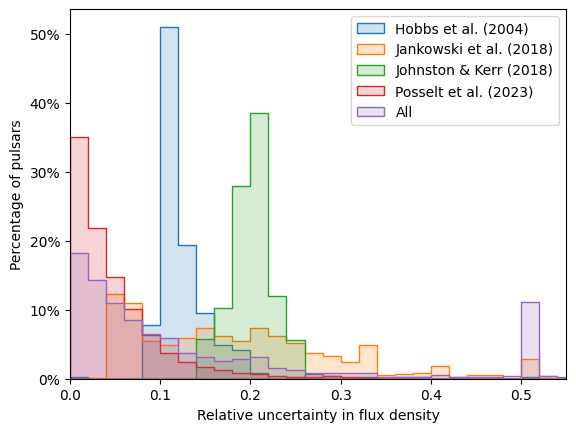

In [2]:
catalogue = load_catalogue(outdir_st)
    
fig, ax = plt.subplots()

def uncertainty_distribution(ref_name: str, caption: str = None, ax=ax, binwidth=0.02, binrange=(0, 0.55)):
    if caption is None and ref_name in catalogue.citation_dict:
        caption = catalogue.citation_dict[ref_name]
    else:
        caption = ref_name
        
    selected_Ys = []
    selected_YERRs = []
    for jname in catalogue.cat_dict.keys():
        if ref_name == 'All':
            selected_Ys.extend(catalogue.cat_dict[jname]['Y'])
            selected_YERRs.extend(catalogue.cat_dict[jname]['YERR'])
        else:
            if ref_name in catalogue.cat_dict[jname]['REF']:
                for i, ref in enumerate(catalogue.cat_dict[jname]['REF']):
                    if ref == ref_name:
                        selected_Ys.append(catalogue.cat_dict[jname]['Y'][i])
                        selected_YERRs.append(catalogue.cat_dict[jname]['YERR'][i])
    
    selected_Ys = np.array(selected_Ys)
    selected_YERRs = np.array(selected_YERRs)
    YERR_Y = selected_YERRs / selected_Ys
    print(f'{caption}: {len(selected_Ys)} measurements')
    
    cosru_10 = np.sum((YERR_Y >= 0.1-0.01) & (YERR_Y < 0.1+0.01))
    cosru_20 = np.sum((YERR_Y >= 0.2-0.01) & (YERR_Y < 0.2+0.01))
    cosru_50 = np.sum((YERR_Y >= 0.5-0.01) & (YERR_Y < 0.5+0.01))
    print('Counts of specific relative uncertainties:')
    print(f'- ~10%: {cosru_10} ({cosru_10 / len(YERR_Y):.1%})')
    print(f'- ~20%: {cosru_20} ({cosru_20 / len(YERR_Y):.1%})')
    print(f'- ~50%: {cosru_50} ({cosru_50 / len(YERR_Y):.1%})')
    
    sns.histplot(YERR_Y, binwidth=binwidth, binrange=binrange,
                 kde=False, label=caption, ax=ax, 
                 stat='probability', element='step', alpha=0.2)
    
uncertainty_distribution('Hobbs_2004a', ax=ax)
uncertainty_distribution('Jankowski_2018', ax=ax)
uncertainty_distribution('Johnston_2018', ax=ax)
uncertainty_distribution('Posselt_2023', ax=ax)
uncertainty_distribution('All', ax=ax)
ax.set_xlim(0, 0.55)
ax.set_xlabel('Relative uncertainty in flux density')
ax.set_ylabel('Percentage of pulsars')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.legend()
plt.savefig('Uncertainty distribution.pdf', bbox_inches='tight')
plt.show()

Number of pulsars with simple power law as the best fitting model: 125
Number of pulsars with simple power law not decisively worst: 295
Number of pulsars with simple power law as the best fitting model (AIC): 203


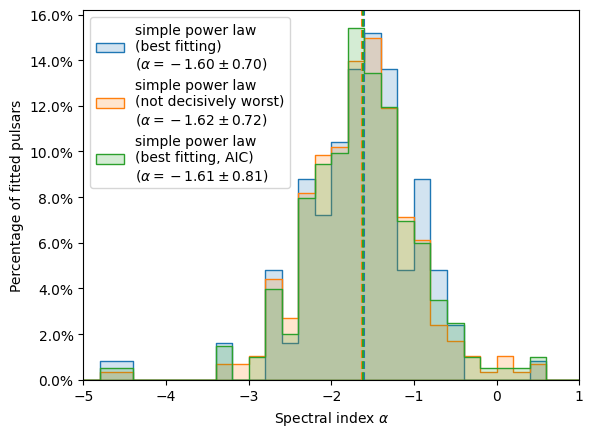

Number of pulsars with simple power law as the best fitting model: 125
Number of pulsars with low-frequency turn-over power law as the best fitting model: 109
Number of pulsars with high-frequency cut-off power law as the best fitting model: 20


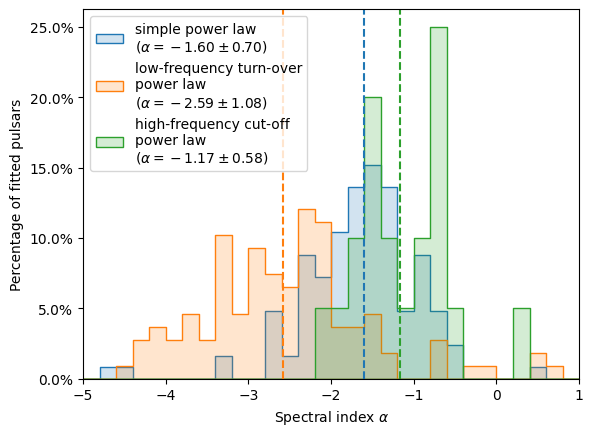

In [3]:
no_best_fit = ['J0452-1759', 'J0511-6508', 'J0517+2212', 'J0536-7543', 'J0656-2228', 'J0711+0931', 'J0738-4042', 'J0751+1807', 'J0834-4159', 'J0842-4851', 'J0901-4624', 'J0902-6325', 'J1020-6026', 'J1028-5819', 'J1043-6116', 'J1052-5954', 'J1114-6100', 'J1126-6054', 'J1126-6942', 'J1302-6350', 'J1305-6203', 'J1352-6803', 'J1357-6429', 'J1410-7404', 'J1420-6048', 'J1513-5739', 'J1534-5334', 'J1535-4114', 'J1559-4438', 'J1617-5055', 'J1626-4807', 'J1632-4757', 'J1636-4440', 'J1637-4642', 'J1638-4608', 'J1645-0317', 'J1650-4502', 'J1652+2651', 'J1702-4128', 'J1705-3950', 'J1709-1640', 'J1717-4054', 'J1727-2739', 'J1734-3333', 'J1735-3258', 'J1740+1000', 'J1743-0339', 'J1747-2958', 'J1751-3323', 'J1758+3030', 'J1803-2137', 'J1804-0735', 'J1804-2717', 'J1806-2125', 'J1809-1917', 'J1812+0226', 'J1815-1738', 'J1816-1729', 'J1819+1305', 'J1820-1529', 'J1822-1400', 'J1824-2452A', 'J1825-1446', 'J1832-1021', 'J1837-0045', 'J1847-0438', 'J1852+0031', 'J1859+1526', 'J1903+0327', 'J1910+0714', 'J1910+1231', 'J1914+1122', 'J1917+0834', 'J1918+1444', 'J1921+1419', 'J1921+2153', 'J1926+1434', 'J1932+1059', 'J1946+1805', 'J2002+1637', 'J2008+2513', 'J2013+3845', 'J2037+1942', 'J2038-3816', 'J2111+2106', 'J2234+0611', 'J2253+1516', 'J2307+2225', 'J2346-0609']
def load_results(outdir: str, var: str):
    with open(f'../output/results_{var}_from_{outdir}.json', 'r', encoding='utf-8-sig') as f:
        results = pd.DataFrame(json.load(f)).T
        results['best_fitting'] = results.iloc[:, :].idxmax(axis=1) if var == 'log_evidence' else results.iloc[:, :].idxmin(axis=1)
        results.loc[no_best_fit, 'best_fitting'] = '(Unclassified)'
    return results
results_st = load_results(outdir_st, 'log_evidence')
results_aic = load_results(outdir_aic, 'aic')
    
results_st_bf = results_st.drop(index=no_best_fit).drop(columns='best_fitting')
results_st_bf = results_st_bf.sub(results_st_bf['simple_power_law'], axis=0).drop(columns='simple_power_law')
results_st_decisive = results_st_bf[results_st_bf > 5.].any(axis=1)
with open(f'../output/results_decisive_from_{outdir_st}.json', 'w', encoding='utf-8-sig') as f:
    json.dump(results_st_decisive.to_dict(), f, ensure_ascii=False, indent=4)

with open(f'../output/results_param_estimates_from_{outdir_st}.json', 'r', encoding='utf-8-sig') as f:
    param_est = json.load(f)

spl_alpha_best, spl_alpha_not_worst, spl_alpha_best_aic = [], [], []
for jname in results_st.index:
    if jname in param_est and 'simple_power_law' in param_est[jname] and jname not in no_best_fit:
        alpha = param_est[jname]['simple_power_law']['median'][0]
        if results_st.loc[jname, 'best_fitting'] == 'simple_power_law':
            spl_alpha_best.append(alpha)
        if jname in results_st_decisive.index and not results_st_decisive[jname]:  # if other models are not decisively better than the simple power law
            spl_alpha_not_worst.append(alpha)
        if jname in results_aic.index and results_aic.loc[jname, 'best_fitting'] == 'simple_power_law':
            spl_alpha_best_aic.append(alpha)
            
lftopl_alpha_best, hfcopl_alpha_best = [], []
for jname in results_st.index:
    if jname in param_est and 'low_frequency_turn_over_power_law' in param_est[jname] and results_st.loc[jname, 'best_fitting'] == 'low_frequency_turn_over_power_law':
        alpha = param_est[jname]['low_frequency_turn_over_power_law']['median'][1]
        lftopl_alpha_best.append(alpha)
    if jname in param_est and 'high_frequency_cut_off_power_law' in param_est[jname] and results_st.loc[jname, 'best_fitting'] == 'high_frequency_cut_off_power_law':
        alpha = param_est[jname]['high_frequency_cut_off_power_law']['median'][1]
        hfcopl_alpha_best.append(alpha)
        
print(f'Number of pulsars with simple power law as the best fitting model: {len(spl_alpha_best)}')
print(f'Number of pulsars with simple power law not decisively worst: {len(spl_alpha_not_worst)}')
print(f'Number of pulsars with simple power law as the best fitting model (AIC): {len(spl_alpha_best_aic)}')
        
fig, ax = plt.subplots()

sns.histplot(spl_alpha_best, binwidth=0.2, binrange=(-5., 1.), kde=False, label=f'simple power law\n(best fitting)\n($α = {np.median(spl_alpha_best):.2f} \pm {np.std(spl_alpha_best):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.2)
sns.histplot(spl_alpha_not_worst, binwidth=0.2, binrange=(-5., 1.), kde=False, label=f'simple power law\n(not decisively worst)\n($α = {np.median(spl_alpha_not_worst):.2f} \pm {np.std(spl_alpha_not_worst):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.2)
sns.histplot(spl_alpha_best_aic, binwidth=0.2, binrange=(-5., 1.), kde=False, label=f'simple power law\n(best fitting, AIC)\n($α = {np.median(spl_alpha_best_aic):.2f} \pm {np.std(spl_alpha_best_aic):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.2)
ylim = ax.get_ylim()
ax.vlines(np.median(spl_alpha_best), *ylim, color='C0', linestyle='--')
ax.vlines(np.median(spl_alpha_not_worst), *ylim, color='C1', linestyle='--')
ax.vlines(np.median(spl_alpha_best_aic), *ylim, color='C2', linestyle='--')
ax.set_ylim(ylim)
ax.set_xlabel('Spectral index $α$')
ax.set_ylabel('Percentage of fitted pulsars')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlim(-5., 1.)
ax.legend(loc='upper left')
plt.savefig('Spectral index distribution (simple power law).pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()

print(f'Number of pulsars with simple power law as the best fitting model: {len(spl_alpha_best)}')
print(f'Number of pulsars with low-frequency turn-over power law as the best fitting model: {len(lftopl_alpha_best)}')
print(f'Number of pulsars with high-frequency cut-off power law as the best fitting model: {len(hfcopl_alpha_best)}')

sns.histplot(spl_alpha_best, binwidth=0.2, binrange=(-5., 1.), kde=False, label=f'simple power law\n($α = {np.median(spl_alpha_best):.2f} \pm {np.std(spl_alpha_best):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.2)
sns.histplot(lftopl_alpha_best, binwidth=0.2, binrange=(-5., 1.), kde=False, label=f'low-frequency turn-over\npower law\n($α = {np.median(lftopl_alpha_best):.2f} \pm {np.std(lftopl_alpha_best):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.2)
sns.histplot(hfcopl_alpha_best, binwidth=0.2, binrange=(-5., 1.), kde=False, label=f'high-frequency cut-off\npower law\n($α = {np.median(hfcopl_alpha_best):.2f} \pm {np.std(hfcopl_alpha_best):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.2)

ylim = ax.get_ylim()
ax.vlines(np.median(spl_alpha_best), *ylim, color='C0', linestyle='--')
ax.vlines(np.median(lftopl_alpha_best), *ylim, color='C1', linestyle='--')
ax.vlines(np.median(hfcopl_alpha_best), *ylim, color='C2', linestyle='--')
ax.set_ylim(ylim)
ax.set_xlabel('Spectral index $α$')
ax.set_ylabel('Percentage of fitted pulsars')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlim(-5., 1.)
ax.legend(loc='upper left')
plt.savefig('Spectral index distribution (comparison).pdf', bbox_inches='tight')
plt.show()

In [4]:
SHOW_PLOTS = False

if SHOW_PLOTS:
    def get_plot(jname: str, model: str):
        file_path = f'../output/{outdir_st}/{jname}/{model}_result.png'
        if not os.path.exists(file_path):
            return
        image = Image.open(file_path)
        image.show()
    
    # get all simple power law pulsars
    spl_best_jnames = []
    for jname in results_st.index:
        if jname in param_est and 'simple_power_law' in param_est[jname] and results_st.loc[jname, 'best_fitting'] == 'simple_power_law':
            spl_best_jnames.append(jname)
    
    for jname in spl_best_jnames:
        get_plot(jname, 'simple_power_law')

Number of pulsars with low-frequency turn-over power law as the best fitting model: 100


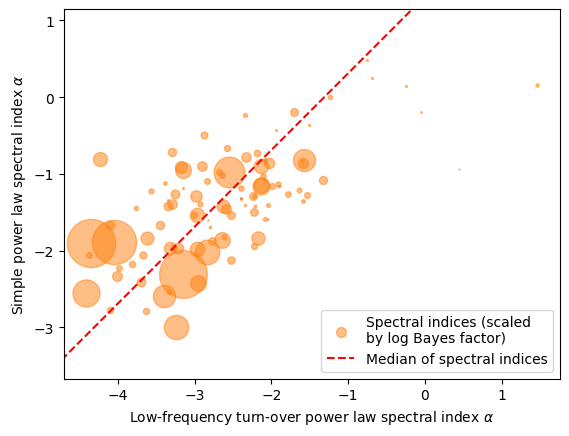

Number of pulsars with high-frequency cut-off power law as the best fitting model: 20


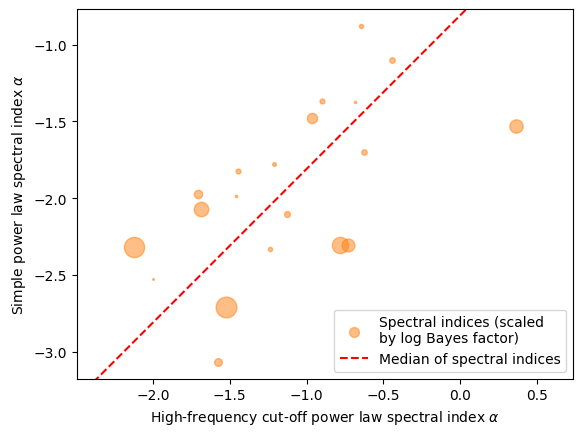

In [5]:
SHOW_PLOTS = False
INTERACTIVE = False
if INTERACTIVE:
    %matplotlib notebook
    import mplcursors

def get_plots(jname: str, models: list):
    images = []
    for i, model in enumerate(models):
        file_path = f'../output/{outdir_st}/{jname}/{model}_result.png'
        if not os.path.exists(file_path):
            continue
        images.append(Image.open(file_path))
    if len(images) > 0:
        Image.fromarray(np.hstack([np.array(image) for image in images])).show()

def plot_aa_scatter(x, y, bf: list, jnames: list, model_name, xlabel, ylabel, xlim = None, ylim = None, title = '', legend_loc='best', ext_out: float=5.):
    fig, ax = plt.subplots()
    scatters, plot_jnames, plot_info = [], [], []
    for i in range(len(x)):
        # if abs(y[i] - x[i] + np.median(x) - np.median(y)) > ext_out:
        #     plot_jnames.append(jnames[i])
        #     plot_info.append(f'Outlier {jnames[i]}: α_x = {x[i]:.2f}, α_y = {y[i]:.2f}, ln BF = {bf[i]:.2f}')
        #     scatter = plt.scatter(x[i], y[i], s=bf[i] * 2, color='tab:blue', alpha=0.5)
        # else:
        scatter = plt.scatter(x[i], y[i], s=bf[i] * 2, color='tab:orange', alpha=0.5)
        scatters.append(scatter)
    if INTERACTIVE and jnames is not None:
        cursor = mplcursors.cursor(scatters, hover=True)
        def get_label(sel):
            ix = np.where(np.array(scatters) == sel.artist)[0][0]
            sel.annotation.set_text(f'{jnames[ix]}\nln BF = {bf[ix]:.2f}\nx = {x[ix]:.2f}\ny = {y[ix]:.2f}')
        cursor.connect('add', get_label)
            
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
        
    # draw a hidden point to show the scatter plot in the legend
    plt.scatter([], [], s=50, alpha=0.5, color='tab:orange', label='Spectral indices (scaled\nby log Bayes factor)')
    # plt.scatter([], [], s=50, alpha=0.5, color='tab:blue', label='Extreme outliers')
    
    x_median = np.median(x)
    y_median = np.median(y)
    intercept = y_median - x_median
    plt.plot([-20, 20], [-20 + intercept, 20 + intercept], 'r--', label='Median of spectral indices')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    plt.ylim(ylim)
    ax.set_aspect('equal', adjustable='datalim')
    plt.legend(loc=legend_loc)
    plt.savefig(f'{title}.pdf', bbox_inches='tight')
    plt.show()
    
    for info, jname in zip(plot_info, plot_jnames):
        print(info)
        if SHOW_PLOTS:
            get_plots(jname, ['simple_power_law', model_name])
    
def aa_scatter(model_name: str, model_name_cap: str, interactive=False, ext_out: float=5.):
    x, y, bf, jnames = [], [], [], []
    for jname in results_st.index:
        if 'simple_power_law' in results_st.columns and model_name in results_st.columns and jname in param_est and 'simple_power_law' in param_est[jname] and model_name in param_est[jname] and results_st.loc[jname, 'best_fitting'] == model_name:
            # If more than half of the points are on the left side of the turn-over, then the simple power law would most likely fit the left side of the plot, thus the comparison becomes pointless.
            turn_over_freq = param_est[jname]['low_frequency_turn_over_power_law']['median'][0]
            X = np.array(catalogue.cat_dict[jname]['X'])
            if np.sum(X < turn_over_freq) / len(X) > 0.5:
                continue
            
            x.append(param_est[jname][model_name]['median'][1])
            y.append(param_est[jname]['simple_power_law']['median'][0])
            bf.append(results_st.loc[jname, model_name] - results_st.loc[jname, 'simple_power_law'])
            jnames.append(jname)
    
    print(f'Number of pulsars with {model_name_cap} as the best fitting model: {len(x)}')
    
    plot_aa_scatter(x, y, model_name=model_name,
                    xlabel=f'{model_name_cap.capitalize()} spectral index $α$',
                    ylabel='Simple power law spectral index $α$',
                    title=f'Spectral index comparison (simple power law vs {model_name_cap})',
                    bf=bf, jnames=jnames,
                    legend_loc='lower right', ext_out=ext_out)
    
aa_scatter('low_frequency_turn_over_power_law', 'low-frequency turn-over power law', interactive=INTERACTIVE, ext_out=2.)
aa_scatter('high_frequency_cut_off_power_law', 'high-frequency cut-off power law', interactive=INTERACTIVE, ext_out=2.)

In [6]:
print('GPS pulsars: peak frequency ∈ [0.6, 2.] GHz')

ν_b_all, ν_c_low_all, ν_c_dtos_all, ν_p_log_all = [], [], [], []
ν_b_best, ν_c_low_best, ν_c_dtos_best, ν_p_log_best = [], [], [], []
for jname in results_st.index:
    best_fitting = results_st.loc[jname, 'best_fitting']
    if best_fitting == 'broken_power_law' and jname in param_est and 'broken_power_law' in param_est[jname]:
        ν_b = param_est[jname]['broken_power_law']['median'][0]
        ν_b_all.append(ν_b)
        if 0.6e3 <= ν_b <= 2.e3:
            ν_b_best.append(ν_b)
    if best_fitting == 'low_frequency_turn_over_power_law' and jname in param_est and 'low_frequency_turn_over_power_law' in param_est[jname]:
        ν_c_low = param_est[jname]['low_frequency_turn_over_power_law']['median'][0]
        ν_c_low_all.append(ν_c_low)
        if 0.6e3 <= ν_c_low <= 2.e3:
            ν_c_low_best.append(ν_c_low)
    if best_fitting == 'double_turn_over_spectrum' and jname in param_est and 'double_turn_over_spectrum' in param_est[jname]:
        ν_c_dtos = param_est[jname]['double_turn_over_spectrum']['median'][1]
        ν_c_dtos_all.append(ν_c_dtos)
        if 0.6e3 <= ν_c_dtos <= 2.e3:
            ν_c_dtos_best.append(ν_c_dtos)
    if best_fitting == 'log_parabolic_spectrum' and jname in param_est and 'log_parabolic_spectrum' in param_est[jname]:
        # calculate the peak manually
        pulsar = catalogue.get_pulsar(jname)
        x = np.logspace(np.log10(np.min(pulsar.X)), np.log10(np.max(pulsar.X)), 1000)
        params = {'a': param_est[jname]['log_parabolic_spectrum']['median'][0],
                  'b': param_est[jname]['log_parabolic_spectrum']['median'][1],
                  'c': param_est[jname]['log_parabolic_spectrum']['median'][2]}
        y = log_parabolic_spectrum(x, params, pulsar.v0)
        ν_p_log = x[np.argmax(y)]  # find the peak frequency
        ν_p_log_all.append(ν_p_log)
        if 0.6e3 <= ν_p_log <= 2.e3:
            ν_p_log_best.append(ν_p_log)
    
print(f'Broken power law: {len(ν_b_best)} / {len(ν_b_all)}')
print(f'Low-frequency turn-over power law: {len(ν_c_low_best)} / {len(ν_c_low_all)}')
print(f'Double turn-over spectrum: {len(ν_c_dtos_best)} / {len(ν_c_dtos_all)}')
print(f'Log-parabolic spectrum: {len(ν_p_log_best)} / {len(ν_p_log_all)}')
print(f'Total: {len(ν_b_best) + len(ν_c_low_best) + len(ν_c_dtos_best) + len(ν_p_log_best)} / {len(ν_b_all) + len(ν_c_low_all) + len(ν_c_dtos_all) + len(ν_p_log_all)}')

GPS pulsars: peak frequency ∈ [0.6, 2.] GHz
Broken power law: 296 / 405
Low-frequency turn-over power law: 32 / 109
Double turn-over spectrum: 47 / 89
Log-parabolic spectrum: 12 / 39
Total: 387 / 642


In [7]:
print('Broken power law: how many of them are having only one point before or after ν_b?', end=' ')

cnt_bpl, cnt_bpl_filtered = 0, 0
for jname in results_st.index:
    if results_st.loc[jname, 'best_fitting'] == 'broken_power_law':
        cnt_bpl += 1
        ν_b = param_est[jname]['broken_power_law']['median'][0]
        X_sorted = np.sort(catalogue.cat_dict[jname]['X'])
        if np.sum(X_sorted < ν_b) <= 1 or np.sum(X_sorted > ν_b) <= 1:
            cnt_bpl_filtered += 1
print(f'{cnt_bpl_filtered} / {cnt_bpl}.')

print('Low-frequency turn-over power law: how many of them are having only one point before or after ν_c?', end=' ')

cnt_lfto, cnt_lfto_filtered = 0, 0
for jname in results_st.index:
    if results_st.loc[jname, 'best_fitting'] == 'low_frequency_turn_over_power_law':
        cnt_lfto += 1
        ν_c = param_est[jname]['low_frequency_turn_over_power_law']['median'][0]
        X_sorted = np.sort(catalogue.cat_dict[jname]['X'])
        if np.sum(X_sorted < ν_c) <= 1 or np.sum(X_sorted > ν_c) <= 1:
            cnt_lfto_filtered += 1
print(f'{cnt_lfto_filtered} / {cnt_lfto}.')

print('Double turn-over spectrum: how many of them are having only one point before or after ν_c2?', end=' ')

cnt_dtos, cnt_dtos_filtered = 0, 0
for jname in results_st.index:
    if results_st.loc[jname, 'best_fitting'] == 'double_turn_over_spectrum':
        cnt_dtos += 1
        ν_c2 = param_est[jname]['double_turn_over_spectrum']['median'][0]
        X_sorted = np.sort(catalogue.cat_dict[jname]['X'])
        if np.sum(X_sorted < ν_c2) <= 1 or np.sum(X_sorted > ν_c2) <= 1:
            cnt_dtos_filtered += 1
print(f'{cnt_dtos_filtered} / {cnt_dtos}.')

Broken power law: how many of them are having only one point before or after ν_b? 68 / 405.
Low-frequency turn-over power law: how many of them are having only one point before or after ν_c? 45 / 109.
Double turn-over spectrum: how many of them are having only one point before or after ν_c2? 68 / 89.
